

## **Analysis of CROCO controls for the Humboldt current system**. 
### Improvements of NCCHILE/Orlando control: Atmospheric forcing validation.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmaps
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime
import geopandas as gpd
import xesmf as xe
from glob import glob
import regionmask
import xgcm
import dask
import os
from dask.diagnostics import ProgressBar

plt.rc('font', size=16)
plt.rc('font', size=16)

In this notebook i will work on the validation of the atmospheric forcing. First i will check the radiative fluxes of ERA5 and then the wind near the coast. For the radiation fluxes i can make a comparison between the forcing and the observational dataset CLARA, or the climatological dataset COADS. For the wind i can compare to ASCAT scaterometer data, and i will perform a more detailed analysis for the wind drop-off near the coast. 

For this drop-off the idea is to check if the interpolation of ERA5 to the model grid is keeping the correct wind diminish near the coast. The real drop-off will be computed with land station data for a coast representative measurement and scaterometers for an open ocean representative metric. Then the difference between the ocean and coastal winds will be the comparison metric for checking the realism of the atmospheric forcing. But first, and more simple i will just see the mean winds (meridional first) and compute some biases against the scatterometer.

In [2]:
#Target dates for the analysis !
ttime = pd.date_range('2006-04','2008', freq='d')[:-1]

In [3]:
#Load grid data
coastmask   = gpd.read_file('~/storage/VECTORIAL/limites/ChileCOASTMASK.shp')
coastline   = gpd.read_file('~/storage/VECTORIAL/limites/lnealitoral/lineadecosta.shp')

#My model
grid = xr.open_dataset('data/CROCO/OUTPUT/TESTSIM/24HERA5_GLORYS12V1/testsim_grd.nc').squeeze().load()
grid = grid[['h','xi_rho','eta_rho','lon_rho','lat_rho','x_rho','y_rho','mask_rho']]
grid['lon_rho'] = (grid.lon_rho+180)%360-180
grid

<xarray.Dataset>
Dimensions:   (eta_rho: 294, xi_rho: 325)
Coordinates:
  * xi_rho    (xi_rho) int64 0 1 2 3 4 5 6 7 ... 317 318 319 320 321 322 323 324
  * eta_rho   (eta_rho) int64 0 1 2 3 4 5 6 7 ... 287 288 289 290 291 292 293
Data variables:
    h         (eta_rho, xi_rho) float32 433.6 433.6 450.8 ... 10.0 10.0 10.0
    lon_rho   (eta_rho, xi_rho) float32 -79.0 -78.97 -78.94 ... -70.03 -70.0
    lat_rho   (eta_rho, xi_rho) float32 -34.0 -34.0 -34.0 ... -27.0 -27.0 -27.0
    x_rho     (eta_rho, xi_rho) float32 -0.03125 2.557e+03 ... 8.912e+05
    y_rho     (eta_rho, xi_rho) float32 -0.03125 -0.03125 ... 7.784e+05
    mask_rho  (eta_rho, xi_rho) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:                     North-Central Chile
    date:                      05-Dec-2022
    type:                      CROCO grid file
    history:                   Fri Jan 27 13:40:48 2023: ncpdq -L 5 -7 backup...
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    nco_openmp_thread_number:  1

---

### Wind and momentum fluxes analysis

Load PLV station data

In [4]:
paths = glob('/ceaza/lucas/storage/PuntaLenguadeVaca/PuntaLenguadeVaca*.csv')
plv   = []
for p in paths:
    data = pd.read_csv(p, skiprows=4)
    data.index = pd.to_datetime(data.iloc[:,1])
    data = data['prom']
    data.name = p.split("_")[-1].split(".")[0]
    plv.append(data)
plv = pd.concat(plv, axis=1).drop_duplicates()
plv = plv.reindex(pd.date_range("2013-11-30 00:00:00","2022-09-13 12:00:00", freq='h'))
plv

,PLVDV,PLVRH,PLVPP,PLVVV,PLVPA,PLVRS,PLVTA
2013-11-30 00:00:00,199.899,87.180,0.0,4.660,1013.270,19.340,12.930
2013-11-30 01:00:00,201.949,87.610,0.0,5.030,1012.880,19.180,12.760
2013-11-30 02:00:00,201.229,87.410,0.0,5.680,1012.450,18.950,12.590
2013-11-30 03:00:00,202.699,87.070,0.0,4.910,1012.350,18.900,12.340
2013-11-30 04:00:00,198.489,87.490,0.0,4.140,1012.480,18.870,12.150
...,...,...,...,...,...,...,...
2022-09-13 08:00:00,205.029,78.407,0.0,3.975,1022.739,314.233,11.483
2022-09-13 09:00:00,214.979,80.023,0.0,4.847,1023.524,348.500,12.077
2022-09-13 10:00:00,218.529,78.972,0.0,5.683,1023.718,459.983,12.505
2022-09-13 11:00:00,220.362,74.500,0.0,6.551,1023.567,800.467,13.248


Load raw ERA5 data

In [5]:
paths = glob('/ceaza/lucas/storage/CROCO/DATA/ERA5/*2006*')+glob('/ceaza/lucas/storage/CROCO/DATA/ERA5/*2007*')
EWSS = []
NSSS = []
U10  = []
V10  = []
for p in paths:
    if ("EWSS" in p):
        EWSS.append(xr.open_dataset(p))
    if ("NSSS" in p):
        NSSS.append(xr.open_dataset(p))
    if ("U10" in p):
        U10.append(xr.open_dataset(p))
    if ("V10" in p):
        V10.append(xr.open_dataset(p))
    
ERA5 = xr.merge([xr.concat(EWSS,'time'), xr.concat(NSSS,'time'), xr.concat(U10,'time'), xr.concat(V10,'time')]).rename({'latitude':'lat','longitude':'lon'})
#Compute wind curl
lon2d,lat2d = np.meshgrid(ERA5.lon, ERA5.lat)
dx = np.cos(np.deg2rad(lat2d))*6371*(np.deg2rad(0.25))*1e3
dy = 6371*np.deg2rad(0.25)*1e3
ERA5.coords['x'] = np.arange(len(ERA5.lon))
ERA5.coords['y'] = np.arange(len(ERA5.lat))
ERA5['wind_curl'] = ERA5.differentiate('x')['v10']/dx-ERA5.differentiate('y')['u10']/dy
ERA5 = ERA5.drop_duplicates('time').sortby('time').resample({'time':'d'}).mean()
ERA5 = ERA5.sel(time=slice(ttime[0], ttime[-1]))
ERA5.coords['time'] = ERA5.time+pd.Timedelta(hours=12)
del EWSS, NSSS, U10, V10

Load simulation forcing (interpolated ERA5 with crocotools)

In [6]:
testsim_aforc = xr.open_zarr('data/ZARR/testim_aforc_nomask/')[['wspd','uwnd','vwnd','lat_rho','lon_rho','mask_rho','x_rho','y_rho']].load().sel(
    time=slice(ttime[0],ttime[-1]))
dx,dy = testsim_aforc.x_rho.differentiate('xi_rho'), testsim_aforc.y_rho.differentiate('eta_rho')
curl  = testsim_aforc['vwnd'].differentiate('xi_rho')/dx-testsim_aforc['uwnd'].differentiate('eta_rho')/dy
testsim_aforc.coords['lat_rho'] = testsim_aforc.lat_rho
testsim_aforc.coords['lon_rho'] = testsim_aforc.lon_rho
testsim_aforc['wind_curl'] = curl.copy()
del curl
testsim_aforc

<xarray.Dataset>
Dimensions:    (time: 639, eta_rho: 294, xi_rho: 325)
Coordinates:
    lat_rho    (eta_rho, xi_rho) float32 -34.0 -34.0 -34.0 ... -27.0 -27.0 -27.0
    lon_rho    (eta_rho, xi_rho) float32 -79.0 -78.97 -78.94 ... -70.03 -70.0
  * eta_rho    (eta_rho) int64 0 1 2 3 4 5 6 7 ... 287 288 289 290 291 292 293
  * time       (time) datetime64[ns] 2006-04-01T12:00:00 ... 2007-12-30T12:00:00
  * xi_rho     (xi_rho) int64 0 1 2 3 4 5 6 7 ... 318 319 320 321 322 323 324
Data variables:
    wspd       (time, eta_rho, xi_rho) float64 3.444 3.464 3.485 ... 1.787 1.78
    uwnd       (time, eta_rho, xi_rho) float64 0.0317 -0.04125 ... 1.624 nan
    vwnd       (time, eta_rho, xi_rho) float64 3.462 3.482 3.503 ... nan nan nan
    mask_rho   (eta_rho, xi_rho) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    x_rho      (eta_rho, xi_rho) float32 -0.03125 2.557e+03 ... 8.912e+05
    y_rho      (eta_rho, xi_rho) float32 -0.03125 -0.03125 ... 7.784e+05
    wind_curl  (time, eta_rho, xi_rho) float64 -3.781e-06 -3.559e-06 ... nan nan
Attributes:
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    date:                      05-Dec-2022
    history:                   Fri Jan 27 13:54:14 2023: ncpdq -L 5 -7 backup...
    nco_openmp_thread_number:  1
    title:                     North-Central Chile
    type:                      CROCO grid file

Load ASCAT data

In [7]:
ASCAT = xr.open_mfdataset('~/storage/ASCAT/*.nc').load().rename({'longitude':'lon','latitude':'lat'}).squeeze()
lon2d,lat2d = np.meshgrid(ASCAT.lon, ASCAT.lat)
dx = np.cos(np.deg2rad(lat2d))*6371*(np.deg2rad(0.25))*1e3
dy = 6371*np.deg2rad(0.25)*1e3
ASCAT.coords['x'] = np.arange(len(ASCAT.lon))
ASCAT.coords['y'] = np.arange(len(ASCAT.lat))
ASCAT['wind_curl'] = ASCAT.differentiate('x')['northward_wind']/dx-ASCAT.differentiate('y')['eastward_wind']/dy
ASCAT

<xarray.Dataset>
Dimensions:                            (time: 5702, lon: 44, lat: 36, x: 44,
                                        y: 36)
Coordinates:
  * time                               (time) datetime64[ns] 2007-03-21T12:00...
  * lon                                (lon) float32 -79.88 -79.62 ... -69.12
  * lat                                (lat) float32 -34.88 -34.62 ... -26.12
    depth                              float32 10.0
  * x                                  (x) int64 0 1 2 3 4 5 ... 39 40 41 42 43
  * y                                  (y) int64 0 1 2 3 4 5 ... 31 32 33 34 35
Data variables:
    wind_speed                         (time, lat, lon) float32 12.23 ... nan
    eastward_wind                      (time, lat, lon) float32 -3.39 ... nan
    northward_wind                     (time, lat, lon) float32 11.41 ... nan
    wind_stress                        (time, lat, lon) float32 0.2779 ... nan
    surface_downward_eastward_stress   (time, lat, lon) float32 -0.0792 ... nan
    surface_downward_northward_stress  (time, lat, lon) float32 0.2664 ... nan
    land_ice_mask                      (time, lat, lon) float32 0.0 0.0 ... 1.0
    wind_speed_rms                     (time, lat, lon) float32 1.5 1.5 ... nan
    eastward_wind_rms                  (time, lat, lon) float32 1.8 1.8 ... nan
    northward_wind_rms                 (time, lat, lon) float32 1.7 1.6 ... nan
    sampling_length                    (time, lat, lon) float32 32.0 ... nan
    wind_curl                          (time, lat, lon) float32 0.0006223 ......
Attributes: (12/25)
    CDI:                      Climate Data Interface version ?? (http://mpime...
    Conventions:              CF-1.4
    history:                  Mon Jan 30 14:20:52 2023: cdo mergetime 2007032...
    source:                   produced at 2011-05-31
    institution:              ifremer
    title:                    Daily ASCAT global wind field
    ...                       ...
    file_quality_index:       0.0
    time_resolution:          daily
    objective_method:         krigeage
    polar_sea_ice_mask_date:  2007-03-21
    creation_date_time:       20110531T232401
    CDO:                      Climate Data Operators version 1.9.3 (http://mp...

Plot mean winds

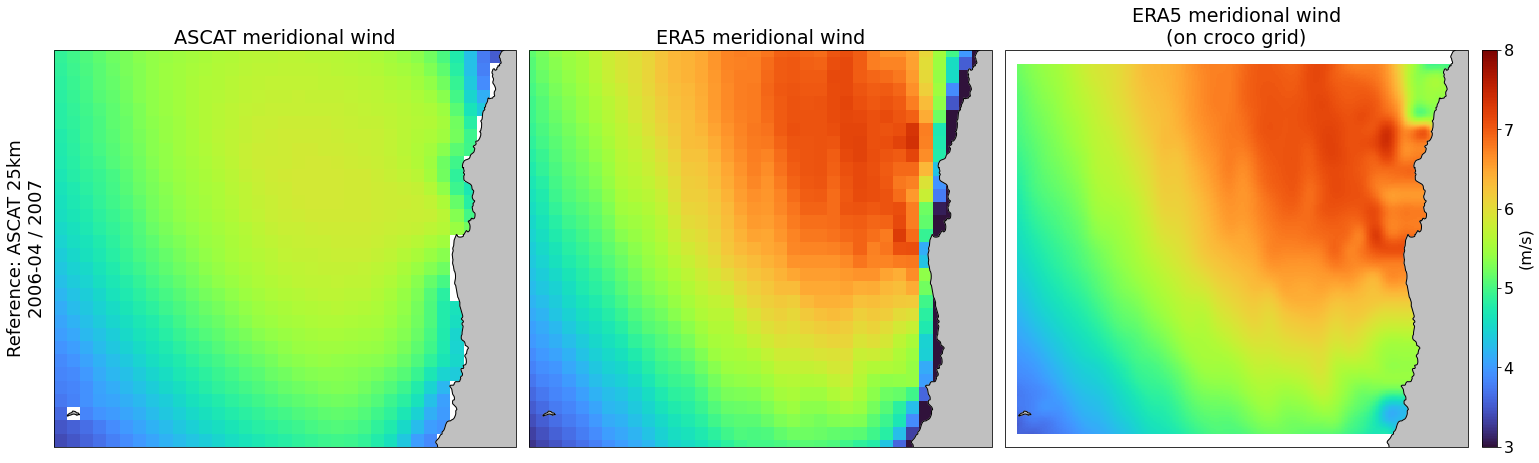

In [360]:
#plot mean winds
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['ASCAT meridional wind','ERA5 meridional wind','ERA5 meridional wind\n(on croco grid)']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
    
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: ASCAT 25km\n2006-04 / 2007', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='turbo'
norm=mcolors.Normalize(3,8)

m = ax[0].pcolormesh(ASCAT.lon, ASCAT.lat, ASCAT['northward_wind'].mean('time'), cmap=cmap, norm=norm)
m = ax[1].pcolormesh(ERA5.lon, ERA5.lat, ERA5.v10.mean('time'), cmap=cmap, norm=norm)
m = ax[2].pcolormesh(testsim_aforc.lon_rho, testsim_aforc.lat_rho, testsim_aforc.vwnd.mean('time'), cmap=cmap, norm=norm)


fig.colorbar(m, cax=cax, label='(m/s)')

The above figure presents the mean meridional wind in ASCAT dataset, the raw ERA5 dataset and the ERA5 wind interpolated to the croco grid with the default croco-tools options (splines and make_ERA5). It can be seen that something happens in the croco-tools interpolation routine that completely removes the coastal wind drop-off!!

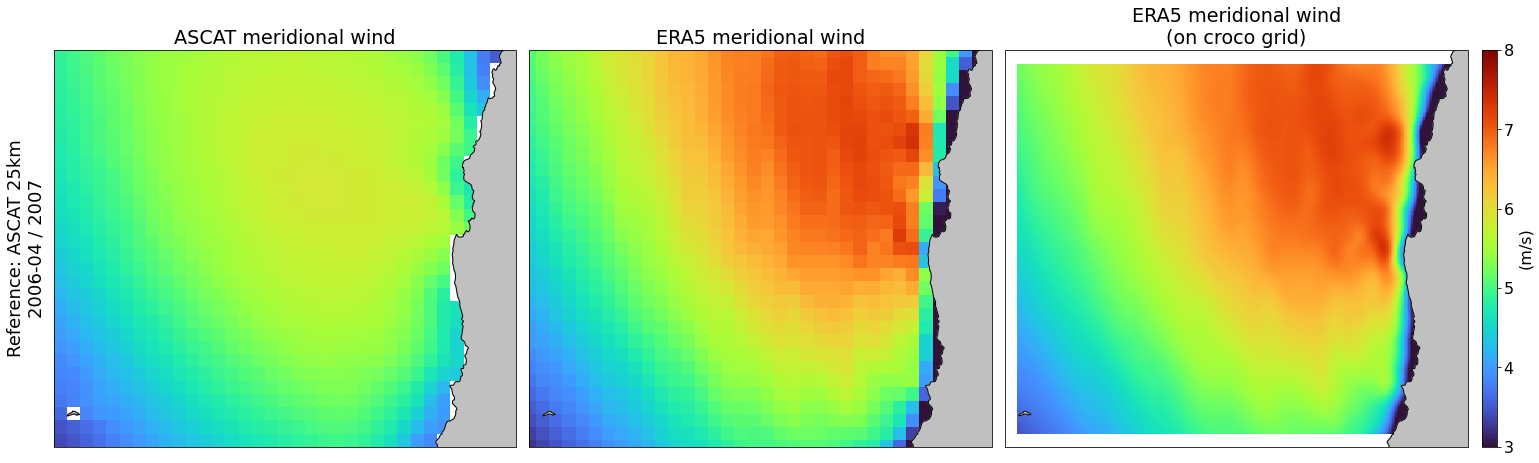

In [9]:
#plot mean winds
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['ASCAT meridional wind','ERA5 meridional wind','ERA5 meridional wind\n(on croco grid)']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
    
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: ASCAT 25km\n2006-04 / 2007', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='turbo'
norm=mcolors.Normalize(3,8)

m = ax[0].pcolormesh(ASCAT.lon, ASCAT.lat, ASCAT['northward_wind'].mean('time'), cmap=cmap, norm=norm)
m = ax[1].pcolormesh(ERA5.lon, ERA5.lat, ERA5.v10.mean('time'), cmap=cmap, norm=norm)
m = ax[2].pcolormesh(testsim_aforc.lon_rho, testsim_aforc.lat_rho, testsim_aforc.vwnd.mean('time'), cmap=cmap, norm=norm)


fig.colorbar(m, cax=cax, label='(m/s)')

The above figure is once again the mean meridional wind from ASCAT, ERA5 and the interpolated ERA5. This time I went to the interpolation routines to find out that when ERA5 was loaded, it was "corrected" with the "get_missing_val" matlab crocotools function. I dont know what that function does (it says that makes an "objective analysis" to fix missing values ¿?), but it is definetly not needed because ERA5 is a full continous dataset with no missing values. 
The new croco_blk forcing files now look like the interpolated ones of the raw ERA5 dataset. I hope that a new simulation with this "true ERA5 forcing" transforms in a significant upgrade of the simulated SST.

In the below cells i will perform a validation analysis on the raw ERA5 data, in terms of biases and correlation against the ASCAT satellite data and the coastal station data.

In [338]:
#Regrid model forcing to reference grid
regridder = xe.Regridder(ERA5,
                         xr.Dataset(coords=ASCAT.coords), method='nearest_s2d')

uwnd = regridder(ERA5.u10)
vwnd = regridder(ERA5.v10)
wspd = regridder(np.hypot(ERA5.u10,ERA5.v10))


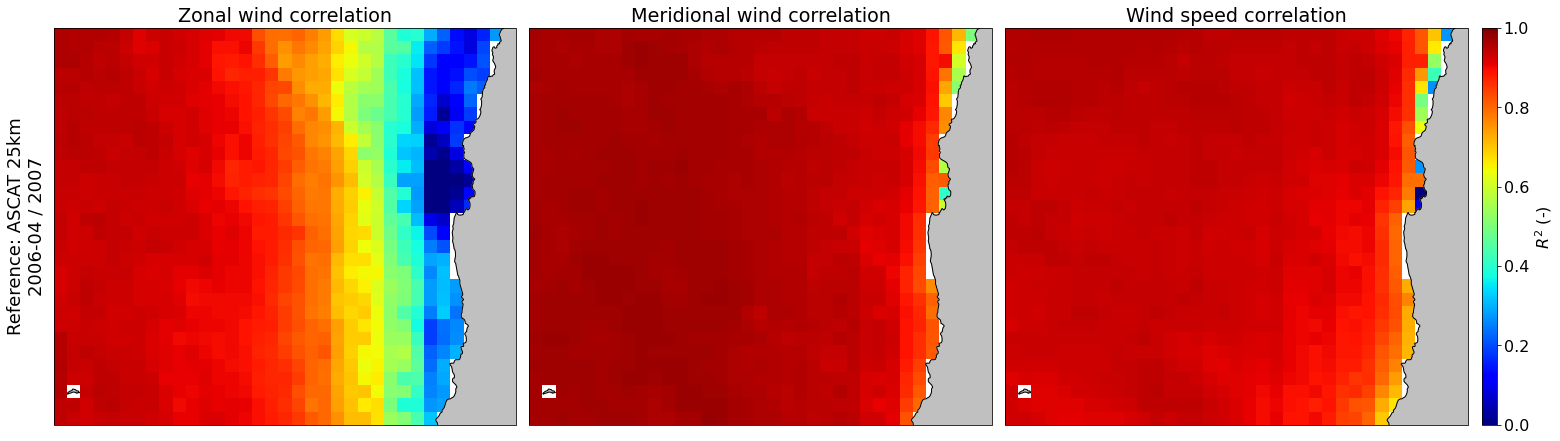

In [341]:
#plot correlations
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['Zonal wind correlation','Meridional wind correlation','Wind speed correlation']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
    
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: ASCAT 25km\n2006-04 / 2007', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='jet'
norm=mcolors.Normalize(0,1)

m=ax[0].pcolormesh(ASCAT.lon, ASCAT.lat, xr.corr(uwnd,ASCAT['eastward_wind'], dim='time'), norm=norm, cmap=cmap)
m=ax[1].pcolormesh(ASCAT.lon, ASCAT.lat, xr.corr(vwnd,ASCAT['northward_wind'], dim='time'), norm=norm, cmap=cmap)
m=ax[2].pcolormesh(ASCAT.lon, ASCAT.lat, xr.corr(wspd,ASCAT['wind_speed'], dim='time'), norm=norm, cmap=cmap)
fig.colorbar(m, cax=cax, label='$R^2$ (-)')


First of all, the above figure shows the squared pearson correlation coefficient between the scatterometer and the ERA5 reanalysis for the wind components (zonal $u$ and meridional $v$) and the total wind speed $\sqrt{u^{2}+v^{2}}$.
It can be seen that the meridional wind and total wind speed has a very high correspondance ($R^2$ > 0.9) except for some pixels near the coast. The zonal component on the other hand, have very low values of $R^2$ near the coast, but high values in the open ocean. Im not so sure if this is a problem of ERA5 or the ASCAT data... 

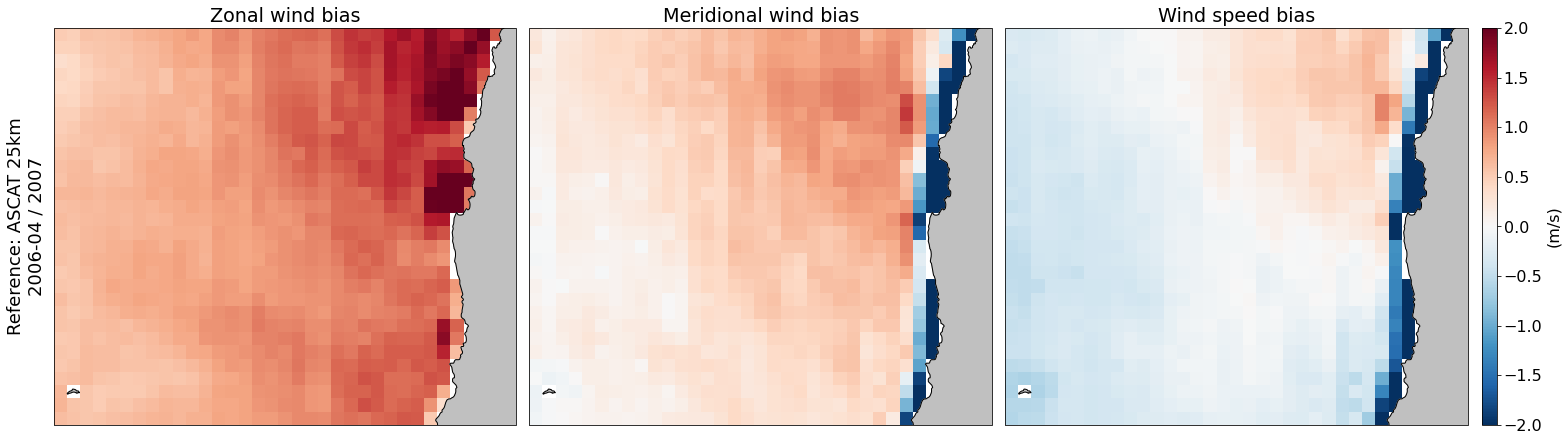

In [340]:
#plot biases
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['Zonal wind bias','Meridional wind bias','Wind speed bias']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
    
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: ASCAT 25km\n2006-04 / 2007', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='RdBu_r'
norm=mcolors.Normalize(-2,2)

m=ax[0].pcolormesh(ASCAT.lon, ASCAT.lat, (uwnd-ASCAT['eastward_wind']).mean('time'), norm=norm, cmap=cmap)
m=ax[1].pcolormesh(ASCAT.lon, ASCAT.lat, (vwnd-ASCAT['northward_wind']).mean('time'), norm=norm, cmap=cmap)
m=ax[2].pcolormesh(ASCAT.lon, ASCAT.lat, (wspd-ASCAT['wind_speed']).mean('time'), norm=norm, cmap=cmap)
fig.colorbar(m, cax=cax, label='(m/s)')


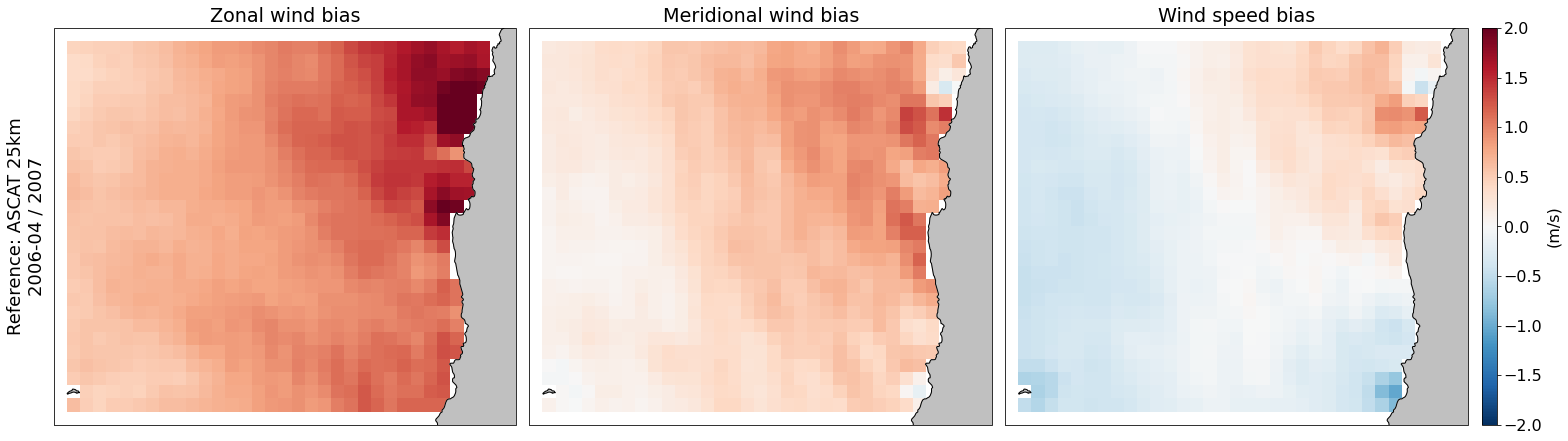

In [326]:
#plot biases
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['Zonal wind bias','Meridional wind bias','Wind speed bias']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
    
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: ASCAT 25km\n2006-04 / 2007', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='RdBu_r'
norm=mcolors.Normalize(-2,2)

m=ax[0].pcolormesh(ASCAT.lon, ASCAT.lat, (uwnd.where(uwnd!=0)-ASCAT['eastward_wind']).mean('time'), norm=norm, cmap=cmap)
m=ax[1].pcolormesh(ASCAT.lon, ASCAT.lat, (vwnd.where(uwnd!=0)-ASCAT['northward_wind']).mean('time'), norm=norm, cmap=cmap)
m=ax[2].pcolormesh(ASCAT.lon, ASCAT.lat, (wspd.where(uwnd!=0)-ASCAT['wind_speed']).mean('time'), norm=norm, cmap=cmap)
fig.colorbar(m, cax=cax, label='(m/s)')
